# Using the Variational Hamiltonian Ansatz on the Hubbard model

The Hubbard model is a simplification of correlated electrons. Despite its simplistic structure, the Hubbard model is able to capture some interesting physics, such as the transition of a solid from a conducting to insulating state and some superconducting effects (though I don't yet understand any of this). 

In this notebook, we'll briefly describe the Hubbard model and then try to use the VHA to solve it. 

$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\braket}[1]{\langle #1 \rangle}$

**Update 1**: I started by defining my own classes/functions for creation/annihilation operators, the Jordan-Wigner transform, the square lattice for the Hubbard Hamiltonian, the Hubbard Hamiltonian's matrix representation, and the Variational Hamiltonian Ansatz (VHA). As expected, my code and computer's RAM wasn't enough to work with anything more than a 2x2 square lattice (which has 8 qubits, so exists 256-dimensional Hilbert space). What did surprise me was how much more efficient OpenFermion was, because when I tried it when SSHing onto a Google Cloud computer, I was able to quickly solve the ground state of up to a 2x10 square lattice Hubbard Hamiltonian. Most of the functions/classes I defined are still available in the tools/ folder if you want to take a look. 

In [1]:
import numpy as np
import scipy.linalg
import scipy.optimize 

from tools.utils import * 
tol = 0.005 # Tolerance for elementwise equality of matrices

<a id="hubbard-ham"></a>
### Defining the Hubbard Hamiltonian 

The Hubbard Hamiltonian: 
$$ H = -t \sum_{\braket{j, k}, \sigma} \Big( c^\dagger_{j\sigma} c_{k\sigma} + c^\dagger_{k \sigma} c_{j \sigma} \Big) + U \sum_j n_{j \uparrow} n_{j \downarrow} - \mu \sum_j \Big(n_{j\uparrow} + n_{j\downarrow} \Big) $$

The first term is kinetic energy, a fermion moving from one site to another. The symbol $\braket{j, k}$ implies iterating over sites that are adjacent. 

The second term is interaction energy, additional energy for a doubly-occupied site. 

The third term is chemical potential, which controls the filling. 

### 2D Hubbard Hamiltonian on a Square Lattice 

We'll use OpenFermion's `HubbardSquareLattice` class to define our lattice. OpenFermion has a simpler function `fermi_hubbard()` to create a `FermionOperator` to describe our system, but this doesn't give us access to the specific hopping terms in the Hamiltonian (the terms in the first summation above), which we'll need for the Variational Hamiltonian Ansatz. 

In [2]:
from openfermion.utils import HubbardSquareLattice
# HubbardSquareLattice parameters
x_n = 2
y_n = 2
n_dofs = 1 # 1 degree of freedom for spin, this might be wrong. Having only one dof means ordered=False. 
periodic = 0 # Not sure what this is, periodic boundary conditions?
spinless = 0 # Has spin

lattice = HubbardSquareLattice(x_n, y_n, n_dofs=n_dofs, periodic=periodic, spinless=spinless)

Now, we'll create a `FermiHubbardModel` instance by passing it our `HubbardSquareLattice` instance defined above. 

To get the `FermionOperator` instance, we need to call `FermiHubbardModel.hamiltonian()`. The [documentation](https://openfermion.readthedocs.io/en/latest/openfermion.html#openfermion.hamiltonians.FermiHubbardModel) isn't that great here, but the [source code](https://github.com/quantumlib/OpenFermion/blob/master/src/openfermion/hamiltonians/_general_hubbard.py) indicates we do indeed get a `FermionOperator` instance which we'll need for calculating ground state, etc. 

We can't just pass an integer for $t$, $U$, or $\mu$ in this class. Instead, we have to specify the *specific* coefficient for each pair and edge type ($t_{ij}^{\textrm{horizontal neighbor}}$). This will be useful later on, I think, because [1506.05135](https://arxiv.org/abs/1506.05135) says we'll need the indices for different values during adiabatic evolution. 

In [40]:
from openfermion.hamiltonians import FermiHubbardModel
from openfermion.utils import SpinPairs
tunneling = [('neighbor', (0, 0), 1.)] # Not sure if this is right
interaction = [('onsite', (0, 0), 2., SpinPairs.DIFF)] # Not sure if this is right
potential = [(0, 1.)]
mag_field = 0. 
particle_hole_sym = False # Not sure if this is right

In [41]:
hubbard = FermiHubbardModel(lattice , tunneling_parameters=tunneling, interaction_parameters=interaction, 
                            potential_parameters=potential, magnetic_field=mag_field, 
                            particle_hole_symmetry=particle_hole_sym)

## Use adiabatic evolution to find correct starting state

Get ground state of Hubbard Hamiltonian so we can check if evolution works.

In [36]:
from openfermion.transforms import get_sparse_operator
from openfermion.utils import get_ground_state 
hub_sparse = get_sparse_operator(hubbard.hamiltonian())
genergy, gstate = get_ground_state(hub_sparse)
print("Ground state energy: ", genergy)

Ground state energy:  -3.627213005296658


Get spectrum of quadratic terms in Hubbard Hamiltonian. I'll call the quadratic sub-Hamiltonian `quad`. 

In [6]:
quad = hubbard.tunneling_terms() + hubbard.potential_terms()
quad_sparse = get_sparse_operator(quad)

Perturb `quad_sparse` with `hub_sparse`. 

In [7]:
s = 1e-3
per_sparse = (1-s)*quad_sparse + s*hub_sparse
w_per, v_per = scipy.sparse.linalg.eigsh(per_sparse, k=np.shape(per_sparse)[0]-2, which='SA')

Now we'll run adiabatic evolution on vectors `v_per[:, i]` until we find one that evolves to have high overlap with `gstate`. 

In [8]:
from openfermion.utils import inner_product
def overlap(a, b):
    """Calculates the overlap between vectors a and b. This metric is also known as fidelity. """
    inner = inner_product(a, b)
    return (np.conjugate(inner) * inner).real

In [9]:
H = lambda s: (1-s)*quad_sparse + s*hub_sparse
best_per_state = None

In [10]:
n = 5
t = 1 
for col in range(v_per.shape[1]):
    state = v_per[:, col]
    for i in range(n):
        s = i / (n-1)
        e = scipy.linalg.expm(-1j * H(s) * t)
#         e = scipy.linalg.expm(-1j * (1-s) * quad_sparse * t) * scipy.linalg.expm(-1j * s * hub_sparse * t)
        state = e.dot(state)
    fid = overlap(state, gstate)
    if fid > .6:
        print("After evolution the fidelity was: ", fid)
        best_per_state = v_per[:, col]
        print(
            "Overlap with perturbed eigenvector and true ground state is: ",
            overlap(best_per_state, gstate))
        break

After evolution the fidelity was:  0.9995704006793082
Overlap with perturbed eigenvector and true ground state is:  0.9420852496880117


When I don't split up the exponents and just pretend we can have no Trotter error, I get arbitrarily close to perfect overlap even with 5 iterations! So Trotter error is the problem...

## Variational Hamiltonian Ansatz

The VHA is an ansatz inspired by time-evolution of the system. It splits the Hamiltonian into sub-operators and then does time-evolution for those operators: 
$$\large U(\theta) = \prod_{k=1}^n \prod_{\alpha=1}^N \exp \Big( i\theta_{\alpha, k} H_{\alpha} \Big) $$
where $H_\alpha$ are the sub-Hamiltonians and $\theta$ are the parameters being optimized. 

**Question:** Why is this a good ansatz? It seems it only has access to states that are evolutions of the state we start with. Why is that a guarantee that it'll approximate the ground state? 

**Answer:** It's based on adiabatic evolution. I don't understand this but somehow if we start by evolving the ground state of a Hamiltonian (non-interacting part in this case) and then slowly start replacing it with another Hamiltonian (full Hubbard Hamiltonian), we get the corresponding ground state of the new Hamiltonian by magic. 

In [1811.04476](https://arxiv.org/pdf/1811.04476.pdf) they use $N=5$, splitting it as I did above: even and odd horizontal hopping terms, even and odd vertical horizontal terms, and the on-site interaction terms. 

In [11]:
from CustomSwapNetworkTrotterAnsatz import *
steps = 2
ansatz = CustomSwapNetworkTrotterAnsatz(hubbard, iterations=steps)

In [12]:
list(ansatz.params())

[ofc.variational.letter_with_subscripts.LetterWithSubscripts('Tv', 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('V', 0, 1, 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('T', 0, 2, 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('T', 1, 3, 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('V', 2, 3, 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('V', 4, 5, 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('T', 4, 6, 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('T', 5, 7, 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('V', 6, 7, 0),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('Tv', 1),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('V', 0, 1, 1),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('T', 0, 2, 1),
 ofc.variational.letter_with_subscripts.LetterWithSubscripts('T', 1, 3, 1),
 ofc.variational.lette

In [13]:
len(list(ansatz.params()))

18

In [14]:
ansatz.default_initial_params()

array([-1.27323954, -0.31830989, -1.27323954, -1.27323954, -0.31830989,
       -0.31830989, -1.27323954, -1.27323954, -0.31830989, -1.27323954,
       -0.95492966, -1.27323954, -1.27323954, -0.95492966, -0.95492966,
       -1.27323954, -1.27323954, -0.95492966])

In [15]:
from openfermioncirq import HamiltonianObjective, VariationalStudy 
from openfermioncirq.optimization import ScipyOptimizationAlgorithm, OptimizationParams

# Define our objective function as the expectation of the Hubbard Hamiltonian
obj = HamiltonianObjective(hubbard.hamiltonian())

# Define our VariationalStudy 
study = VariationalStudy(
    'Hubbard-VHA', 
    ansatz, 
    obj, 
    initial_state=best_per_state)

# Choose our optimization algorithm 
algorithm = ScipyOptimizationAlgorithm(kwargs={'method': 'L-BFGS-B'}, uses_bounds=True)
optimization_params = OptimizationParams(algorithm=algorithm)

# Optimize 
result = study.optimize(optimization_params)

print("Optimal ground state energy is {}".format(result.optimal_value))

Optimal ground state energy is -6.7637299809927915


In [16]:
from cirq import resolve_parameters

optimal_params = study.trial_results[0].optimal_parameters
VHA_ground_state = resolve_parameters(
    study.circuit, study.ansatz.param_resolver(optimal_params)).final_wavefunction(best_per_state)

print("VHA ground state and true ground state have an overlap of {}".format(
    overlap(VHA_ground_state, gstate)))

VHA ground state and true ground state have an overlap of 0.9915909585791025


Okay, I just got an overlap of 0.9996060048066143 ! Never mind, this was when I did adiabatic evolution without Trotter error and then used the final state as input.

TAKE 2: YES! I got 0.9915908481547779 with `SwapNetworkTrotter`!

Okay! So it seem SNTH has different configuration for which qubits are spins (first 4 are spin up, last 4 are spin down) but SNT has alternating (qubit 1 is UP, qubit 2 is DOWN,...). When I did with this latter schema, it worked. So I guess there's some inconsistency... maybe my objective function is using the latter while SNTH used the former? Anyway, I got 0.99156 again with single U parameter (chemical), 4 V parameters (potential), and 8 T parameters per iteration for 2 iterations. 

### Analyzing optimal parameters 

In [17]:
optimal_params

array([-1.50000789, -0.50000044, -1.31165256, -0.99999799, -0.50000081,
       -0.50000076, -0.99999776, -1.3116527 , -0.50000052, -1.45990039,
       -0.99998178, -1.00003692, -0.99999749, -0.9999818 , -0.99998177,
       -0.99999729, -1.00003706, -0.99998175])

First 8 U's are the same. 4 V's are the same. T's are quite different...

We have 15 parameters - 3 for each of the 5 steps. Notice the first 2 of each step (the tunneling term parameters) are the same, like we'd expect for adiabatic evolution. The final parameter in each step seems to increment by a constant amount. Looks like we exactly followed adiabatic evolution...

**UPDATE**: it doesn't look like it's following adiabatic evolution at all! I copied the result in case this doesn't always happen (Nevermind this happened when we didn't use Trotter error for adiabatic evolution and used the final state as input): 

```
array([-0.00496074, -0.99857477, -0.99782215,  0.22178394, -1.99953177,
        1.        ,  0.38438499, -1.99758694,  1.        ,  0.18889494,
       -2.        ,  0.9994578 , -0.03240713, -1.99841714,  0.99809175])
```


### Analyzing ground state

First, let's see how many non-zero elements the state vector of the ground state has: 

In [18]:
total_elems = 0
for elem in VHA_ground_state: 
    if np.abs(elem) > tol: 
        total_elems += 1
print("The {}-dimensionsal ground state vector has {} non-zero elements.".format(
    VHA_ground_state.shape[0], total_elems))

The 256-dimensionsal ground state vector has 26 non-zero elements.


Great! It's very sparse. If there was only 1 non-zero element, then we could decompose it into tensor products in the computational basis state easily. Let's see what the individual elements are. 

In [19]:
# Make sure norm is 1 
print("Norm is {}".format(np.linalg.norm(VHA_ground_state)))
             
# This finds every distinct element in VHA_ground_state (up to a tolerance) 
# and counts its occurences
common_elems = {}
for elem in VHA_ground_state: 
    # Check if it's already in common_elems 
    array_common_elems = [complex(e) for e in list(common_elems.keys())]
    match = np.isclose(array_common_elems, elem, rtol=0, atol=tol)
    if match.any():
        common_elems[str(array_common_elems[match.argmax()])] += 1
    else: 
        common_elems[str(elem)] = 1
        
print("The distinct elements in the ground state vector along with their counts are: \n", common_elems)

Norm is 0.9999999999999998
The distinct elements in the ground state vector along with their counts are: 
 {'(3.531258445458908e-17-5.922244357515916e-17j)': 230, '(0.13220990142922787-0.026623965735303918j)': 2, '(-0.1457495950673554+0.029375359631333996j)': 8, '(0.14574967059926694-0.029375393396486413j)': 8, '(-0.13220837508680697+0.026621492869915202j)': 2, '(-0.21431512028801808+0.043186885224212636j)': 4, '(0.4286326142324688-0.08637203956647686j)': 2}


Interesting, 10 of the non-zero elements have the same value, let's call this $a$. And the other 6 have the value $-a$. I guess I could decompose this into a sum of 16 pure states, but I don't think we'll get much insight into the system with that...

Let's just get the average measurement for each of the qubits. 

In [38]:
from cirq import measure_state_vector

hundred_thousand_measurements = np.array(
    [measure_state_vector(VHA_ground_state, range(2 *x_n*y_n))[0] for _ in range(100000)])
np.mean(hundred_thousand_measurements, axis=0)

array([0.25065, 0.24719, 0.25079, 0.24927, 0.24908, 0.25056, 0.24948,
       0.25298])

Well that's boring! Each qubit has an average value of 0.5. They're completely uniform! 

Let's think about what this means. We used Jordan-Wigner encoding which means the qubit corresponding to a spin-orbital is $\ket{1}$ if there's an electron in that spin-orbital, and $\ket{0}$ if there isn't. The uniform is indeed half-filling. 

This also means we don't prefer any spin over the other, which makes it unlikely magnetic moments will form. 

In [22]:
for trial in hundred_thousand_measurements: 
    if np.count_nonzero(trial) != x_n*y_n: 
        print(np.count_nonzero(trial))

Nothing printed, so we didn't get a *single measurement* where we didn't have four $\ket{1}$'s. This means I was wrong. The ground state distribution *isn't* random: it's entangled in some way to give us at most 4 electrons in the 4 site model. (Of course, we set $\mu$ in order to get this half-filling behavior but it's nice to verify that it works 100% of the time.)

Well, this is more interesting. I wonder if the spin-up and spin-down results are correlated in any way. Here's how we'll check this: the first 4 qubits correspond to spin-up and the last 4 qubits correspond to spin-down so that indices $i$ and $i+4$ correspond to the spin-up and spin-down electrons on the $i$th site. This means if there're always two $\ket{1}$'s in the first 4 qubits and two $\ket{1}$'s in the last 4 qubits, there're always 2 spin-up and 2 spin-down electrons in every ground state. 

We can also check how often they're on the same site, though I suspect we'll never find 2 electrons on the same site because of the interaction energy $U$. 

In [23]:
n_states_unequal_spins = 0
n_states_correlated_spins = 0
for trial in hundred_thousand_measurements: 
    spin_up_qubits = trial[:x_n*y_n]
    spin_down_qubits = trial[x_n*y_n:]
    
    if np.count_nonzero(spin_up_qubits) != np.count_nonzero(spin_down_qubits):
        n_states_unequal_spins += 1
    
    for i in range(x_n*y_n):
        if spin_up_qubits[i] == 1 and spin_down_qubits[i] == 1: 
            n_states_correlated_spins += 1
            break

print("Number of trials with unequal spin-up and spin-down electrons: ", n_states_unequal_spins)
print("Number of trials with at least 2 electrons on the same site: ", n_states_correlated_spins)

Number of trials with unequal spin-up and spin-down electrons:  21187
Number of trials with at least 2 electrons on the same site:  30908


Huh, looks like both my guesses were wrong. In about 1/5 of the trials, we had unequal spin-up and spin-down electrons. *This means there's a chance for magnetism.* It also turns out that in about 1/3 of the trials, the ground state had a fully occupied site, which I didn't expect because of the additional interaction energy associated with it. 

Finally, let's look at the distribution of electron spins. We know that we sometimes get a nonzero local moment, but I suspect the number of trials with spin-up and spin-down local moments will be roughly equal. 

In [31]:
hundred_thousand_measurements[0][::2]

array([0, 1, 1, 0])

In [28]:
hundred_thousand_measurements[0]

array([0, 1, 1, 0, 1, 0, 0, 1])

In [32]:
total_spin_ups = []
for trial in hundred_thousand_measurements: 
    # We only care about number of qubits here. Since we know we always 
    # have 4 total qubits, we can look only at the spin-ups. 
#     spin_up_qubits = trial[:x_n*y_n] 
    spin_up_qubits = trial[::2]
    n_spin_ups = np.count_nonzero(spin_up_qubits)
    # n_states_spin_up[str(n_spin_ups)] += 1
    total_spin_ups.append(n_spin_ups)

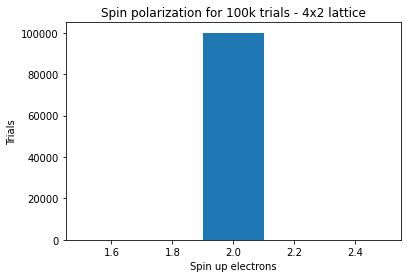

In [39]:
import matplotlib.pyplot as plt
plt.hist(total_spin_ups, bins=5)
# plt.hist(total_spin_ups)
plt.title("Spin polarization for 100k trials - 4x2 lattice")
plt.xlabel("Spin up electrons")
plt.ylabel("Trials")
plt.show()
# plt.savefig("symmetric_spins_4x2.png")

## Rewriting SNTHA to take into account chemical potential

Huh, the indices for T terms are different compared to SNT... Was I wrong about up-down spins to qubits?